# A Dynamic Subscriber Problem

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from interpolation import interp
from scipy.optimize import minimize_scalar

## Set up

### A simple model 

In the basic version of the model, the number of new subscribers per period is $n(p_t)$, where $n$ is a given function and $p_t$ is the current price (subscription fee).

In a simple linear model, the number of subscribers evolves according to

$$ 
    s_{t+1} = (1 - \delta) s_t + n(p_t)
$$

Here $\delta$ is the cancellation rate, so that $\delta s_t$ is the number merchants that cancel their subscription.

### Network effects

Let's now assume there are nonlinear network effects.

Now the number of subscribers evolves according to

$$ 
    s_{t+1} = (1 + \delta(p_t)) s_t + n(s_t, p_t)
$$

The difference is that

* the cancellation rate can depend on the fee and
* the number of new subscribers depends on the number of existing subscribers

We rewrite these dynamics as 

$$
   s_{t+1} = f(s_t, p_t)
$$

where 

$$
   f(s, p) = (1 - \delta(p)) s + h(s) m(p)
$$

We assume that

* $h$ is increasing in $s$ -- more subscribers encourages more subscribers
* $m$ is decreasing in $p$ -- a higher fee reduces the flow of subscribers

For $h$ we use 



In [830]:
def h(x, μ=2.0, σ=1.0):
    return 2 * (1/σ) * np.exp(-(x - μ)**2 / (2 * σ**2))

Here is a plot of the function.

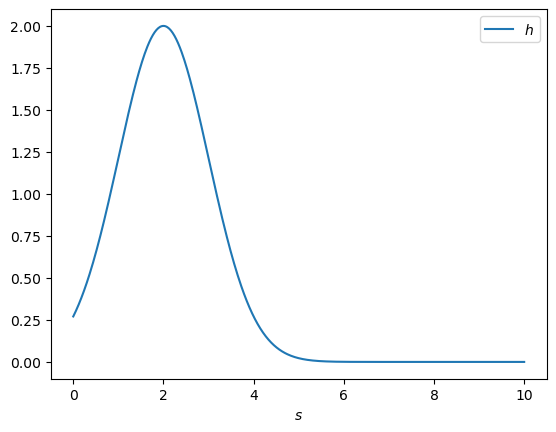

In [831]:
s_grid = np.linspace(0, 10, 500)
fig, ax = plt.subplots()
ax.plot(s_grid, h(s_grid), label="$h$")
ax.set_xlabel('$s$')
ax.legend()
plt.show()

The function $m$, which captures the flow of subscribers as a function of price, is given by

In [832]:
def m(p, 1.0, b=10.0):
    return a * np.exp(- b * p)

SyntaxError: invalid syntax (2714065999.py, line 1)

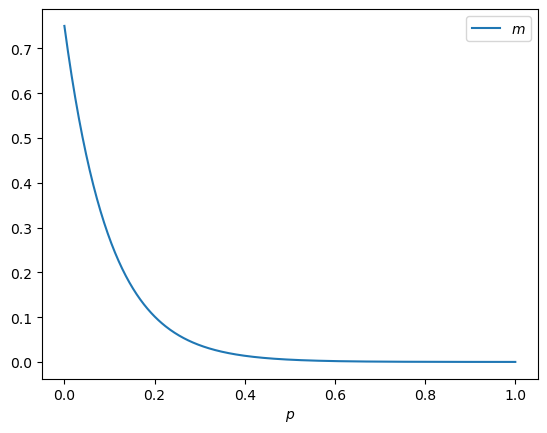

In [833]:
p_grid = np.linspace(0, 1, 500)
fig, ax = plt.subplots()
ax.plot(p_grid, m(p_grid), label="$m$")
ax.set_xlabel('$p$')
ax.legend()
plt.show()

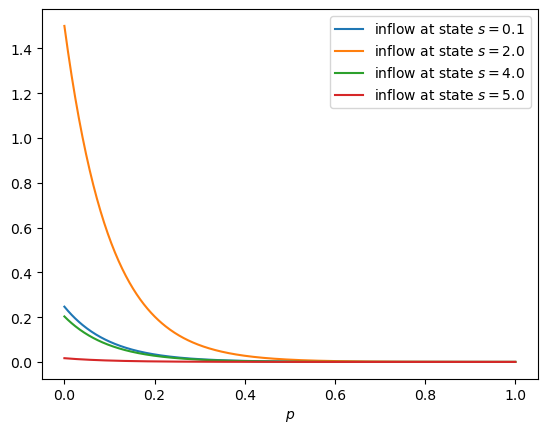

In [834]:
p_grid = np.linspace(0, 1, 500)
s_vals = 0.1, 2.0, 4.0, 5.0

fig, ax = plt.subplots()
for s in s_vals:
    ax.plot(p_grid, m(p_grid) * h(s), label=f"inflow at state $s={s}$")
ax.set_xlabel('$p$')
ax.legend()
plt.show()

The cancellation rate is given by

In [835]:
def δ(p, κ=0.1, γ=20.0):
    return κ + (1 - np.exp(- γ * p)) * (1 - κ)

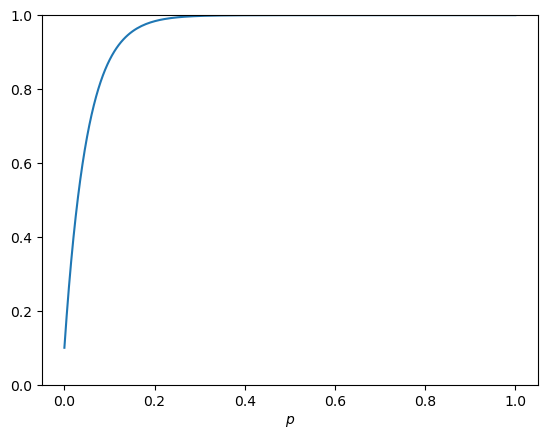

In [836]:
p_grid = np.linspace(0, 1, 200)
fig, ax = plt.subplots()
ax.plot(p_grid, δ(p_grid))
ax.set_ylim(0, 1)
ax.set_xlabel('$p$')
plt.show()

### Dynamics under a fixed price

For a given price, the dynamics for subscribers are given by

In [837]:
def f(s, p):
    return (1 - δ(p)) * s + h(s) * m(p)

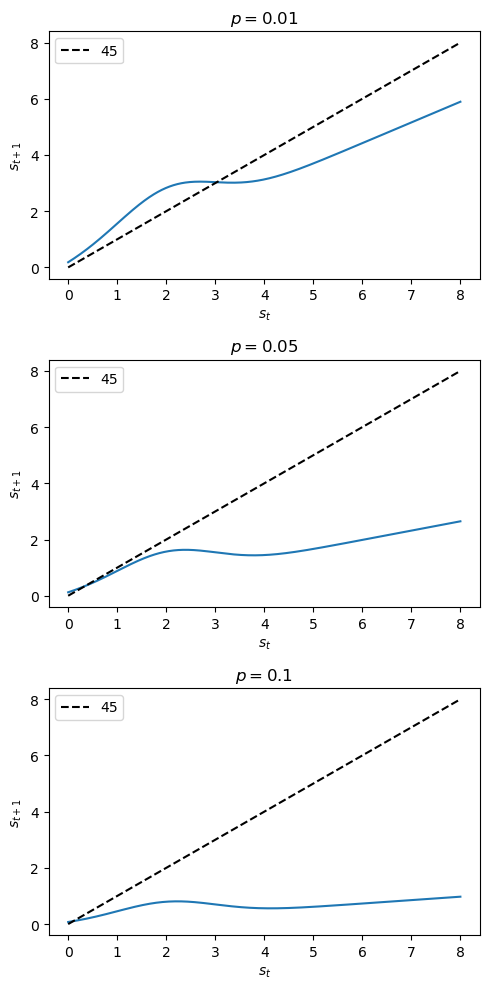

In [838]:
p_vals = 0.01, 0.05, 0.1
s_grid = np.linspace(0, 8, 500)
fig, axes = plt.subplots(len(p_vals), 1, figsize=(5, 10))
for p, ax in zip(p_vals, axes):
    ax.plot(s_grid, f(s_grid, p))
    ax.plot(s_grid, s_grid, 'k--', label='45')
    ax.legend()
    ax.set_xlabel('$s_t$')
    ax.set_ylabel('$s_{t+1}$')
    ax.set_title(f'$p = {p}$')
fig.tight_layout()
plt.show()

## Dynamic programming code

The Bellman equation is

$$
   v(s) = \max_{p \geq 0}
   \left\{
   s p + \beta v(f(s, p))
   \right\}
$$




In [839]:
def B(s, p, v_vals, model):
    """
    Right hand side of the Bellman equation given s and p.

        * s_grid is a set of possible subscriber values
        * v_vals is the values of the value function on the grid
    """
    s_grid = model.s_grid
    β = model.β
    n = model.n
    v = lambda s: interp(s_grid, v_vals, s)

    return p * s + β * v(f(s, p))

In [840]:
def T(v_vals, model):

    v_new = np.empty_like(v_vals)

    for i, s in enumerate(model.s_grid):
        v_new[i] = np.max(B(s, model.p_grid, v_vals, model))

    return v_new

In [841]:
def get_greedy(v_vals, model):

    p_star = np.empty_like(v_vals)
    
    for i, s in enumerate(model.s_grid):
        p_max_index = np.argmax(B(s, model.p_grid, v_vals, model))
        p_star[i] = model.p_grid[p_max_index]

    return p_star

In [842]:
def compute_value_function(model,
                           tol=1e-4,
                           max_iter=10_000,
                           verbose=True,
                           print_skip=100):

    # Set up loop
    v = np.ones(len(model.s_grid)) # Initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v, model)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return v_new

In [843]:
class Model:

    def __init__(self, 
                 n=n, 
                 s_grid_min=0,
                 s_grid_max=10,
                 s_grid_size=200,
                 p_grid_size=100,
                 β=0.99):
        self.f, self.n = f, n
        self.s_grid = np.linspace(s_grid_min, s_grid_max, s_grid_size)
        self.p_grid = np.linspace(0, 1, p_grid_size)
        self.β = β 

In [844]:
model = Model()
n = model.n
s_grid = model.s_grid

In [845]:
v = compute_value_function(model)
p_vec = get_greedy(v, model)
p_star = lambda s: interp(s_grid, p_vec, s)

Error at iteration 100 is 0.2503147899940643.
Error at iteration 200 is 0.08515685630938208.
Error at iteration 300 is 0.03050243322201851.
Error at iteration 400 is 0.010878060831423397.
Error at iteration 500 is 0.003939810130475507.
Error at iteration 600 is 0.001416980701712589.
Error at iteration 700 is 0.0005045608092117959.
Error at iteration 800 is 0.00017892695476007248.

Converged in 858 iterations.


Here's the optimal fee strategy as a function of the state $s$

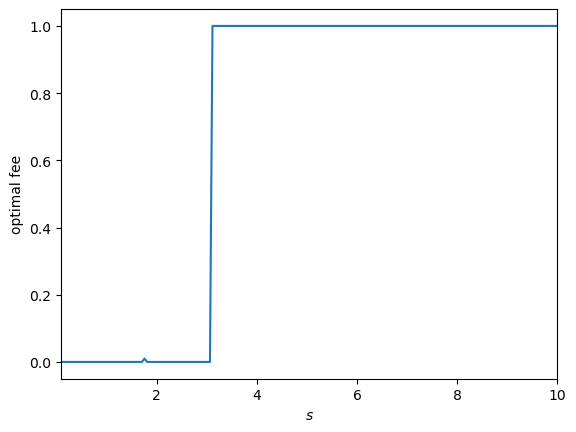

In [846]:
fig, ax = plt.subplots()
ax.plot(s_grid, p_star(s_grid))
ax.set_xlim(0.1, s_grid.max())
ax.set_ylabel("optimal fee")
ax.set_xlabel("$s$")
plt.show()

Here's the 45 degree diagram that shows the dynamics of 

$$
    s_{t+1} = f(s_t, p^*(s_t))
$$

In [847]:
def g(s):
    return f(s, p_star(s))

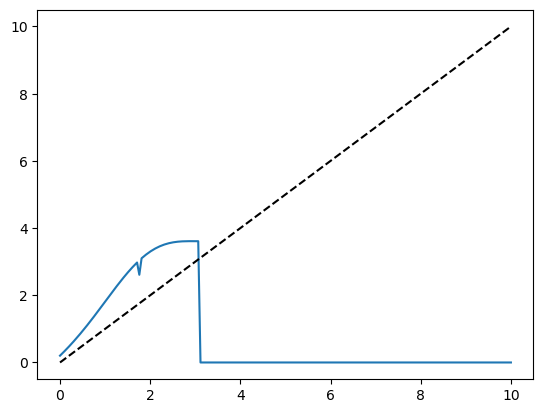

In [848]:
fig, ax = plt.subplots()
ax.plot(s_grid, g(s_grid))
ax.plot(s_grid, s_grid, 'k--')
plt.show()